In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
image_size = 64
transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

flowers_train = torchvision.datasets.Flowers102('', split = "train", transform =transform, download=True)

100%|██████████| 344862509/344862509 [00:01<00:00, 214212067.18it/s]


Extracting flowers-102/102flowers.tgz to flowers-102


100%|██████████| 502/502 [00:00<00:00, 1895176.06it/s]


100%|██████████| 14989/14989 [00:00<00:00, 43507558.93it/s]


In [46]:
batch_size = 204
dataloaders = {'train': DataLoader(flowers_train, batch_size=batch_size)}

dataset_sizes = {'train': len(flowers_train)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1020}


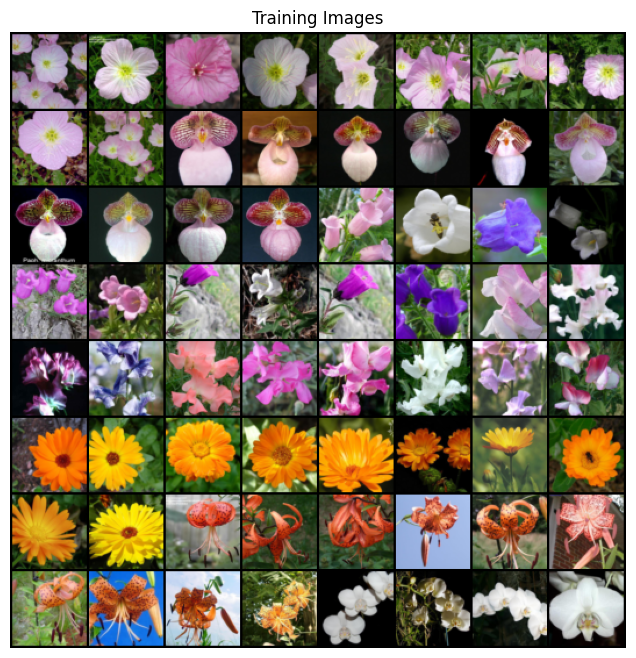

In [47]:
# Visualization function borrowed from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Plot some training images
real_batch = next(iter(dataloaders["train"]))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [49]:
# Number of channels in the training images.
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [50]:
# Discriminator definition
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.pipeline = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.pipeline(input)

# Generator definition
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.pipeline = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.pipeline(input)

In [51]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [52]:
# Create model instances
netD = Discriminator(nc, ndf).to(device)
netG = Generator(nc, nz, ngf).to(device)

# Weight initialization
netD.apply(weights_init)
netG.apply(weights_init)

# Print the models
print(netD)
print(netG)

Discriminator(
  (pipeline): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_si

In [53]:
# Training adapted from: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
real_label = 1.
fake_label = 0.

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

def train_GANS(netD, netG, dataloaders, dataset_sizes, criterion, optimizerD, optimizerG, num_epochs=25):
    since = time.time()
    
    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    training_curves['G'] = [] # for generator
    training_curves['D'] = [] # for discriminator
    phase = 'train'
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for _, inputs in enumerate(dataloaders[phase], 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            optimizerD.zero_grad()
            # Format batch
            real_cpu = inputs[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            training_curves['D'].append(errD.item())
            training_curves['G'].append(errG.item())

            print(f'D Loss: {errD.item():.4f}  G Loss: {errG.item():.4f}')

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    return netD, netG, training_curves


In [54]:
# Number of training epochs
num_epochs = 100 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Loss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Train the model. We also will store the results of training to visualize
netD, netG, training_curves = train_GANS(netD, netG, dataloaders, dataset_sizes, 
                                     criterion, optimizerD, optimizerG, num_epochs=num_epochs)


Epoch 1/100
----------
D Loss: 2.4095  G Loss: 5.8865
D Loss: 1.3770  G Loss: 4.5685
D Loss: 1.3792  G Loss: 5.2074
D Loss: 1.1089  G Loss: 6.3367
D Loss: 0.9773  G Loss: 6.3052

Epoch 2/100
----------
D Loss: 1.4745  G Loss: 7.0725
D Loss: 1.2224  G Loss: 8.0967
D Loss: 1.2084  G Loss: 6.7414
D Loss: 1.4799  G Loss: 10.7228
D Loss: 0.8114  G Loss: 7.3326

Epoch 3/100
----------
D Loss: 1.8422  G Loss: 10.5738
D Loss: 1.0429  G Loss: 7.5887
D Loss: 1.5223  G Loss: 11.7577
D Loss: 0.6163  G Loss: 8.8169
D Loss: 1.1654  G Loss: 11.5527

Epoch 4/100
----------
D Loss: 0.6154  G Loss: 8.8055
D Loss: 1.3663  G Loss: 12.5725
D Loss: 0.4964  G Loss: 9.7706
D Loss: 0.8385  G Loss: 12.1156
D Loss: 0.4217  G Loss: 9.3684

Epoch 5/100
----------
D Loss: 2.0948  G Loss: 16.3451
D Loss: 0.8439  G Loss: 13.9144
D Loss: 0.3993  G Loss: 7.0196
D Loss: 3.4920  G Loss: 17.7548
D Loss: 0.4399  G Loss: 18.3632

Epoch 6/100
----------
D Loss: 0.5519  G Loss: 12.1932
D Loss: 0.5531  G Loss: 7.3853
D Loss: 

In [55]:
torch.save(netG.state_dict(), "netG.model")
torch.save(netD.state_dict(), "netD.model")

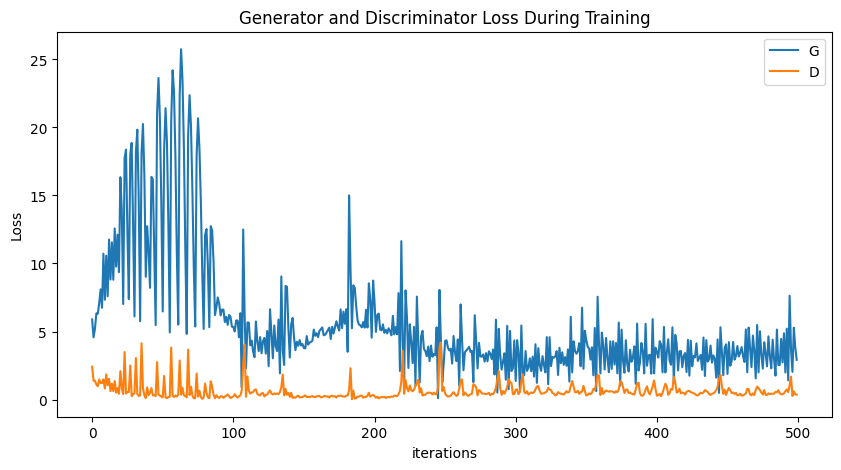

In [56]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(training_curves['G'] ,label="G")
plt.plot(training_curves['D'] ,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

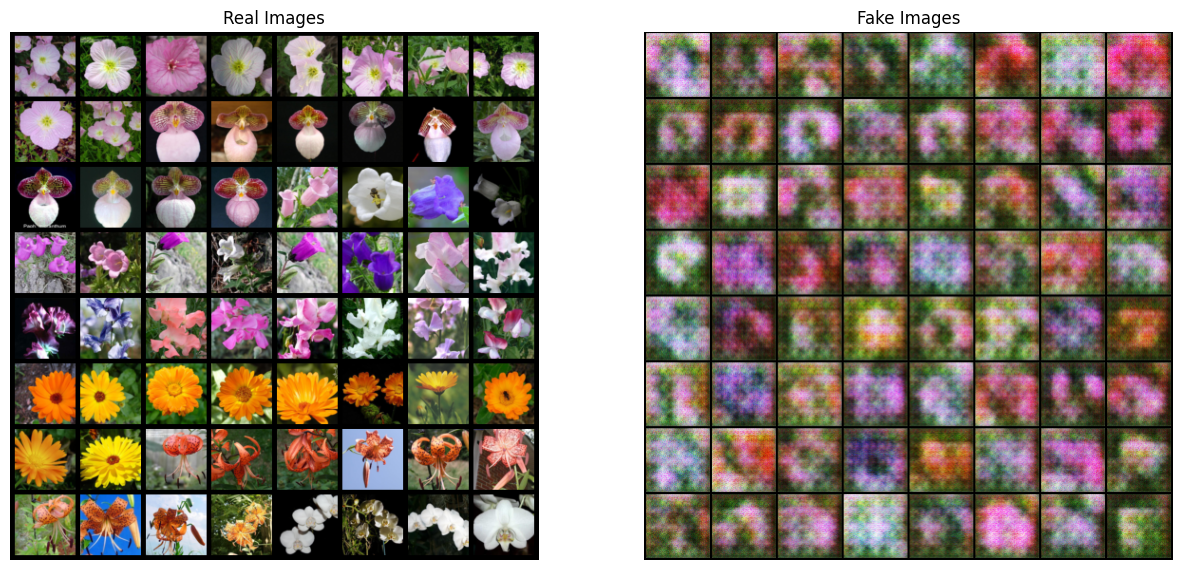

In [57]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloaders['train']))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Generate Fake images
img_list = []
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()